In [2]:
%matplotlib inline

from ultralytics import YOLO
import os
import yaml
import sys
from matplotlib import pyplot as plt
from math import ceil
import numpy as np
import seaborn as sns
import cv2

sys.path.append("..")
from dev.display import draw_yolo_boxes
from src.processing.consts import DATASET_BASE_PATH
from train.yolo import show_gt_and_pred, read_ground_truth
from dev.utils import print_results_yolo, get_fp_fn_images, save_img_and_log

In [3]:
MODELS = { 
    "form8_sea":  "../models/sea-form8_sea_aug-random_best.pt",
    "form8_sea_onnx": "../models/sea-form8_sea_aug-random_best.onnx",    
    "form8_mandrac": "../models/mandrac_form8_random-sub_best.pt",
    "form8_mandrac-hamburg": "../models/mandrac-hamburg_form8_random-sub_best.pt",
    "form2_mandrac": "../models/mandrac_form2_random-sub_best.pt",
    "form2_mandrac-hamburg": "../models/mandrac-hamburg_form2_random-sub_best.pt",
}

CONFIDENCE = 0.3
OUT_PATH = "../out/summary"

ONE_CLASS_DIR = "one_class"
TWO_CLASS_DIR = "two_classes"
PILE_DIR = "pile_only"
LITTER_DIR = "litter_only"

DATASET_FORM8 = {
    "name": "hamburg mapping N G form8",
    "dataset_path": f"{DATASET_BASE_PATH}/created/hamburg_mapping-form8-val",
    "config_name": "hamburg_mapping-form8-val.yaml",
    "two_class": True,
}

DATASET_FORM8_INV = {
    "name": "hamburg mapping form8 G N (inverse)",
    "dataset_path": f"{DATASET_BASE_PATH}/created/hamburg_mapping-inverse-form8-val",
    "config_name": "hamburg_mapping-inverse-form8-val.yaml",
    "two_class": True,
}

DATASET_FORM2 = {
    "name ": "hamburg mapping N G form2",
    "dataset_path": f"{DATASET_BASE_PATH}/created/hamburg_mapping-form2-val",
    "config_name": "hamburg_mapping-form2-val.yaml",
    "two_class": True,
}

DATASETS = [DATASET_FORM8, DATASET_FORM8_INV, DATASET_FORM2]

In [4]:
def change_labels(dataset_path, dir):
    if os.path.exists(f"{dataset_path}/{dir}"):
        !rm -rf {dataset_path}/labels
        !ln -s {dataset_path}/{dir} {dataset_path}/labels
        print(f"labels changed to {dir}")
    else:
        print(f"labels directory {dataset_path}/{dir} does not exist, keeping old labels")

# SHOW ANNOTATIONS

In [10]:
def show_annotations(dataset_path, config_name, output_dir, filename, all_channels=False):
    for split in ("train", "val", "test"):
        if not os.path.exists(f"{dataset_path}/images/{split}"):
            print(f"Images directory for {split} does not exist in {dataset_path}/images/")
            continue
        files = os.listdir(f"{dataset_path}/images/{split}")
        if len(files) == 0:
            print(f"No images found in {dataset_path}/images/{split}")
            continue

        if not all_channels:
            # RGB or channel 0 only
            rgb_files = [f for f in files if f.endswith(('_RGB.png'))]
            files = rgb_files if rgb_files else [f for f in files if f.endswith(('_ch0.tif', '_ch0.tiff'))]

            if len(files) == 0:
                print(f"No image with RGB or channel 0 found in {dataset_path}/images/{split}")
                continue

        files.sort()

        n_cols = 7 if len(files) > 7 else len(files)
        n_rows = ceil(len(files) / n_cols)

        fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols*4, n_rows*3))

        with open(f"{dataset_path}/{config_name}", "r") as file:
            config = yaml.safe_load(file)

        for fn, ax in zip(files, axs.flatten()):
            ax.set_title(fn)
            ax.axis("off")
            image, annots = draw_yolo_boxes(f"{dataset_path}/images/{split}/{fn}", 
                            f"{dataset_path}/labels/{split}/{os.path.splitext(fn)[0] + '.txt'}",
                            config["names"], display=False)
            ax.imshow(image)

        plt.tight_layout()
        plt.savefig(f"{output_dir}/{filename}_annots-{split}.jpg")
        plt.close()

        print(f"Saved annotations for {split} to {output_dir}/{filename}_annots-{split}.jpg")

In [ ]:
ds_names = ["mandrac0",  "mandrac1", "mandrac2", "mandrac3", "hamburg_mapping", "hamburg_pile", "mandrac_no_litter", "hamburg_no_litter"]
dataset_paths = [f"{DATASET_BASE_PATH}/annotated/{ds}" for ds in ds_names]

for dataset_path, name in zip(dataset_paths, ds_names):
    show_annotations(dataset_path, "data_config.yaml", f"{OUT_PATH}/annots", f"{name}")

Saved annotations for train to ../out/summary/mandrac0.jpg
No images found in /home/anna/Datasets//annotated/mandrac0/images/val
Images directory for test does not exist in /home/anna/Datasets//annotated/mandrac0/images/
Saved annotations for train to ../out/summary/mandrac1.jpg
Images directory for val does not exist in /home/anna/Datasets//annotated/mandrac1/images/
Images directory for test does not exist in /home/anna/Datasets//annotated/mandrac1/images/
Saved annotations for train to ../out/summary/mandrac2.jpg
Images directory for val does not exist in /home/anna/Datasets//annotated/mandrac2/images/
Images directory for test does not exist in /home/anna/Datasets//annotated/mandrac2/images/
Saved annotations for train to ../out/summary/mandrac3.jpg
Images directory for val does not exist in /home/anna/Datasets//annotated/mandrac3/images/
Images directory for test does not exist in /home/anna/Datasets//annotated/mandrac3/images/
Saved annotations for train to ../out/summary/hamburg

In [13]:
for dataset in DATASETS:
    print(dataset['name'])
    change_labels(dataset["dataset_path"], TWO_CLASS_DIR)
    show_annotations(dataset["dataset_path"], dataset["config_name"], f"{OUT_PATH}/annots", dataset["name"].replace(' ', '-'), all_channels=True)

hamburg mapping N G form8
labels changed to two_classes
No images found in /home/anna/Datasets//created/hamburg_mapping-form8-val/images/train
Saved annotations for val to ../out/summary/annots/hamburg-mapping-N-G-form8_annots-val.jpg
No images found in /home/anna/Datasets//created/hamburg_mapping-form8-val/images/test
hamburg mapping form8 G N (inverse)
labels changed to two_classes
No images found in /home/anna/Datasets//created/hamburg_mapping-inverse-form8-val/images/train
Saved annotations for val to ../out/summary/annots/hamburg-mapping-form8-G-N-(inverse)_annots-val.jpg
No images found in /home/anna/Datasets//created/hamburg_mapping-inverse-form8-val/images/test


# Evaluate model

In [5]:
def save_images(pred_results, dataset, output_dir, title="", confidence=CONFIDENCE):
    # save gt and pred images
    fp_image, fn_image = get_fp_fn_images(pred_results, confidence)

    change_labels(dataset['dataset_path'], TWO_CLASS_DIR)
    gt, classes = read_ground_truth(pred_results)
    image = show_gt_and_pred(pred_results, gt, n_cols=6, gt_classes=classes, show_empty=False, verb=False)

    save_img_and_log(image, f"{output_dir}/preds-gt_{title.replace(' ', '-')}_conf-{confidence}.jpg")
    save_img_and_log(fp_image, f"{output_dir}/fps_{title.replace(' ', '-')}_conf-{confidence}.jpg")
    save_img_and_log(fn_image, f"{output_dir}/fns_{title.replace(' ', '-')}_conf-{confidence}.jpg")

def evaluate_model(model_name, dataset, names, two_class=True, confidence=CONFIDENCE, postfix="", our_litter_only=False, onnx=False):
    model = YOLO(MODELS[model_name])
    ds_path = dataset['dataset_path']
    output_dir = f"{OUT_PATH}/{model_name}_model{postfix}_results"
    os.mkdir(output_dir)

    label_dirs = [ONE_CLASS_DIR, PILE_DIR, LITTER_DIR] if two_class else ["-"]
    if our_litter_only:
        label_dirs = [PILE_DIR]
        names = ["Our litter only"]
    for label_dir, name in zip(label_dirs, names):
        if two_class:
            change_labels(ds_path, label_dir)

        val_results = model.val(data=f"{ds_path}/{dataset['config_name']}", plots=True, verbose=False, imgsz=(800, 608))
        pred_results = model.predict(source=f"{ds_path}/images/val", save=False, conf=confidence, verbose=False, imgsz=(800, 608))

        print_results_yolo(val_results, name, filename=f"{output_dir}/metrics_conf-{confidence}.txt")
        save_images(pred_results, dataset, output_dir, name, confidence=confidence)


def evaluate_onnx_model(model_path, dataset, names, two_class=False, confidence=CONFIDENCE):
    ds_path = dataset['dataset_path']
    label_dirs = [ONE_CLASS_DIR, PILE_DIR, LITTER_DIR] if two_class else ["-"]
    for label_dir, name in zip(label_dirs, names):
        if two_class:
            change_labels(ds_path, label_dir)

    session = ort.InferenceSession(model_path)
    input_name = session.get_inputs()[0].name

    for img_path in os.listdir(f"{ds_path}/images/val"):
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Add batch dimension: (1, C, H, W)
        input = np.transpose(image, (2, 1, 0))
        input = np.expand_dims(input, axis=0)

        # Detection
        print("Detecting litter...")
        results = session.run(None, {input_name: input})

        # bbs = []
        # for pred_bbs in results[0]:
        #     for bb in pred_bbs:
        #         x1, y1, x2, y2, conf, cls = bb
        #         # filter if needed: e.g., if conf > 0.5
        #         if conf > CONFIDENCE:
        #             rect = Rectangle(y1, x1, y2, x2, "rect")
        #             bbs.append(rect)     


In [27]:
model_name = "form8_sea"
postfix = " "
dataset = DATASET_FORM8

model = YOLO(MODELS[model_name])
ds_path = dataset['dataset_path']

label_dirs = [PILE_DIR]
names = ["Our litter only"]
for label_dir, name in zip(label_dirs, names):
    change_labels(ds_path, label_dir)
    val_results = model.val(data=f"{ds_path}/{dataset['config_name']}", plots=True, verbose=False)
    pred_results = model.predict(source=f"{ds_path}/images/val", save=False, conf=CONFIDENCE, verbose=False)

    # print_results_yolo(val_results, name)
    # save_images(pred_results, dataset, output_dir, name, confidence=confidence)

labels changed to pile_only
Ultralytics 8.3.74 🚀 Python-3.8.20 torch-2.4.1+cu121 CPU (13th Gen Intel Core(TM) i7-13700H)
YOLOv10n summary (fused): 285 layers, 2,694,806 parameters, 0 gradients, 8.2 GFLOPs


val: Scanning /home/anna/Datasets/created/hamburg_mapping-form8-val/labels/val.cache... 317 images, 279 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:50<00:00,  2.54s/it]


                   all        317         38       0.19      0.605      0.191      0.137
Speed: 1.8ms preprocess, 142.2ms inference, 0.0ms loss, 0.1ms postprocess per image
Results saved to runs/detect/val69


In [78]:
val_results.box.mr, val_results.box.mp

(0.6052631578947368, 0.18978005429775238)

In [74]:
confidence_thresholds = val_results.curves_results[1][0]
f1_scores = val_results.curves_results[1][1]

optimal_idx = np.argmax(f1_scores)
optimal_confidence = confidence_thresholds[optimal_idx]
optimal_recall = val_results.curves_results[3][1].T[optimal_idx]
optimal_precision = val_results.curves_results[2][1].T[optimal_idx]
print(f"Optimal confidence threshold: {optimal_confidence:.4f}, which gives recall {optimal_recall[0]:.4f} and precision {optimal_precision[0]:.4f}")

Optimal confidence threshold: 0.4494, which gives recall 0.6053 and precision 0.2051


In [33]:
# Get optimal confidence threshold for class 0 (assuming "Litter" is class 0)
f1_scores = val_results.box.f1  # F1-scores at various thresholds
conf_thresholds = val_results.curves_results[1][0]  # Confidence thresholds from F1-C curve

# Find threshold that maximizes F1 for class 0
optimal_idx = np.argmax(f1_scores[0])
optimal_threshold = conf_thresholds[optimal_idx]

print(f"Optimal confidence threshold for recall: {optimal_threshold:.3f}")

Optimal confidence threshold for recall: 0.000


## EVALUATE OLD MODEL (USED IN HAMBURG)

In [20]:
model_name = "form8_sea"

EVALUATING MODEL ON N G form8 DATASET
labels changed to pile_only
Ultralytics 8.3.74 🚀 Python-3.8.20 torch-2.4.1+cu121 CPU (13th Gen Intel Core(TM) i7-13700H)
YOLOv10n summary (fused): 285 layers, 2,694,806 parameters, 0 gradients, 8.2 GFLOPs


val: Scanning /home/anna/Datasets/created/hamburg_mapping-form8-val/labels/val.cache... 317 images, 279 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:36<00:00,  1.83s/it]


                   all        317         38       0.19      0.605      0.183      0.136
Speed: 1.8ms preprocess, 96.9ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/detect/val68


OUR LITTER ONLY VALIDATION RESULTS

Results:
mAP50: 0.183
mAP50-95: 0.136
Precision: 0.190
Recall: 0.605
F1: 0.289



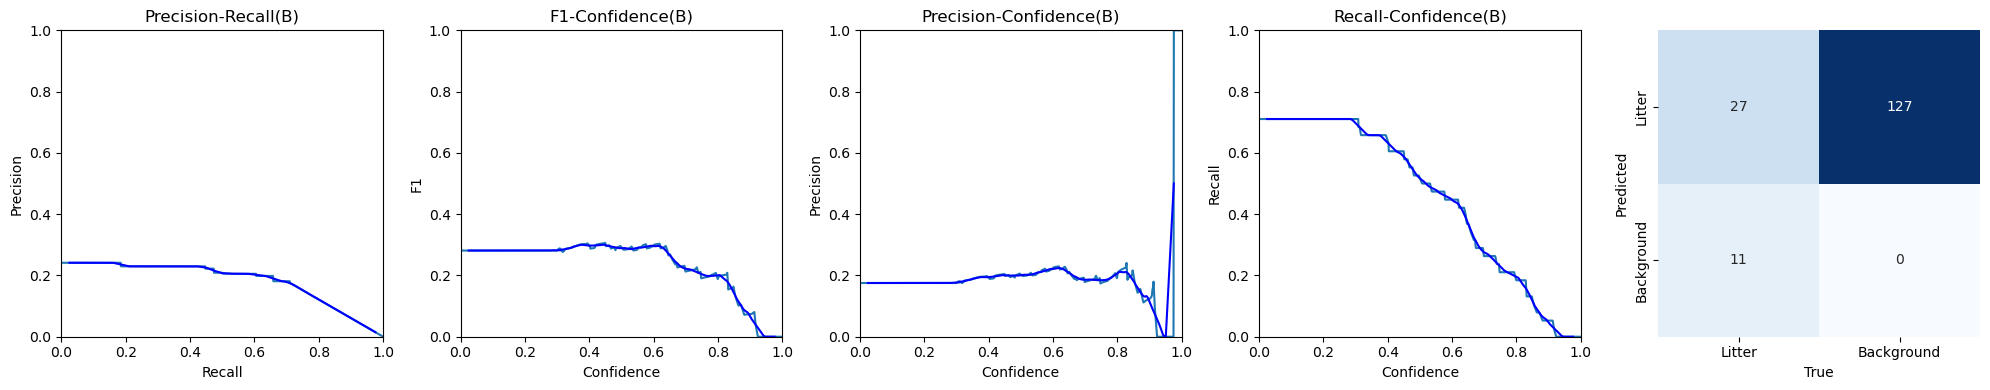

labels changed to two_classes
Saved image to ../out/summary/form8_sea_model-conf_results/preds-gt_Our-litter-only_conf-0.3.jpg
Saved image to ../out/summary/form8_sea_model-conf_results/fps_Our-litter-only_conf-0.3.jpg
Saved image to ../out/summary/form8_sea_model-conf_results/fns_Our-litter-only_conf-0.3.jpg


In [22]:
print("EVALUATING MODEL ON N G form8 DATASET")
evaluate_model(model_name, DATASET_FORM8, ["all present litter", "only our litter", "only present litter"], postfix="-conf", our_litter_only=True)

EVALUATING MODEL ON form8 G N DATASET
labels changed to one_class
Ultralytics 8.3.74 🚀 Python-3.8.20 torch-2.4.1+cu121 CPU (13th Gen Intel Core(TM) i7-13700H)
YOLOv10n summary (fused): 285 layers, 2,694,806 parameters, 0 gradients, 8.2 GFLOPs


val: Scanning /home/anna/Datasets/created/hamburg_mapping-inverse-form8-val/labels/val.cache... 317 images, 166 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:30<00:00,  1.52s/it]


                   all        317        435      0.296     0.0943      0.058     0.0364
Speed: 1.3ms preprocess, 82.1ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/detect/val52


ALL PRESENT LITTER (INVERSE) VALIDATION RESULTS

Results:
mAP50: 0.058
mAP50-95: 0.036
Precision: 0.296
Recall: 0.094
F1: 0.143



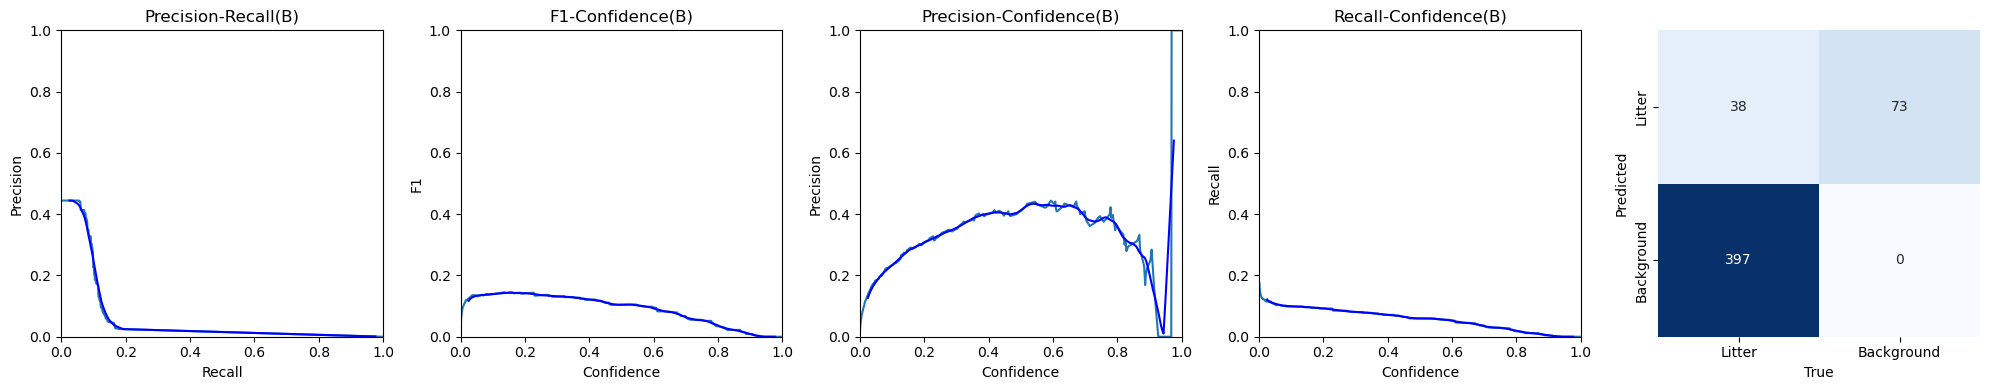

labels changed to two_classes
Saved image to ../out/summary/form8_sea_model-inv_results/preds-gt_all-present-litter-(inverse)_conf-0.3.jpg
Saved image to ../out/summary/form8_sea_model-inv_results/fps_all-present-litter-(inverse)_conf-0.3.jpg
Saved image to ../out/summary/form8_sea_model-inv_results/fns_all-present-litter-(inverse)_conf-0.3.jpg
labels changed to pile_only
Ultralytics 8.3.74 🚀 Python-3.8.20 torch-2.4.1+cu121 CPU (13th Gen Intel Core(TM) i7-13700H)


val: Scanning /home/anna/Datasets/created/hamburg_mapping-inverse-form8-val/labels/val.cache... 317 images, 279 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:30<00:00,  1.53s/it]


                   all        317         38       0.34      0.684      0.352      0.256
Speed: 1.3ms preprocess, 82.9ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/detect/val53


ONLY OUR LITTER (INVERSE) VALIDATION RESULTS

Results:
mAP50: 0.352
mAP50-95: 0.256
Precision: 0.340
Recall: 0.684
F1: 0.454



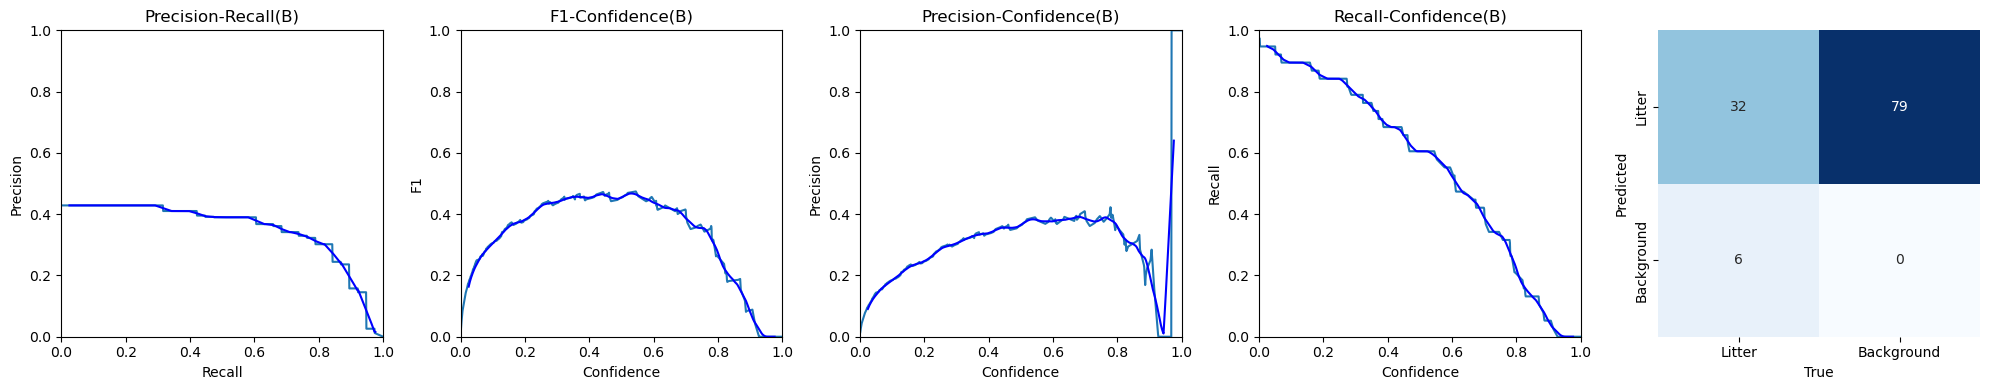

labels changed to two_classes
Saved image to ../out/summary/form8_sea_model-inv_results/preds-gt_only-our-litter-(inverse)_conf-0.3.jpg
Saved image to ../out/summary/form8_sea_model-inv_results/fps_only-our-litter-(inverse)_conf-0.3.jpg
Saved image to ../out/summary/form8_sea_model-inv_results/fns_only-our-litter-(inverse)_conf-0.3.jpg
labels changed to litter_only
Ultralytics 8.3.74 🚀 Python-3.8.20 torch-2.4.1+cu121 CPU (13th Gen Intel Core(TM) i7-13700H)


val: Scanning /home/anna/Datasets/created/hamburg_mapping-inverse-form8-val/labels/val.cache... 317 images, 184 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:43<00:00,  2.19s/it]


                   all        317        397     0.0408     0.0252    0.00965    0.00442
Speed: 1.5ms preprocess, 121.4ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/detect/val54


ONLY PRESENT LITTER (INVERSE) VALIDATION RESULTS

Results:
mAP50: 0.010
mAP50-95: 0.004
Precision: 0.041
Recall: 0.025
F1: 0.031



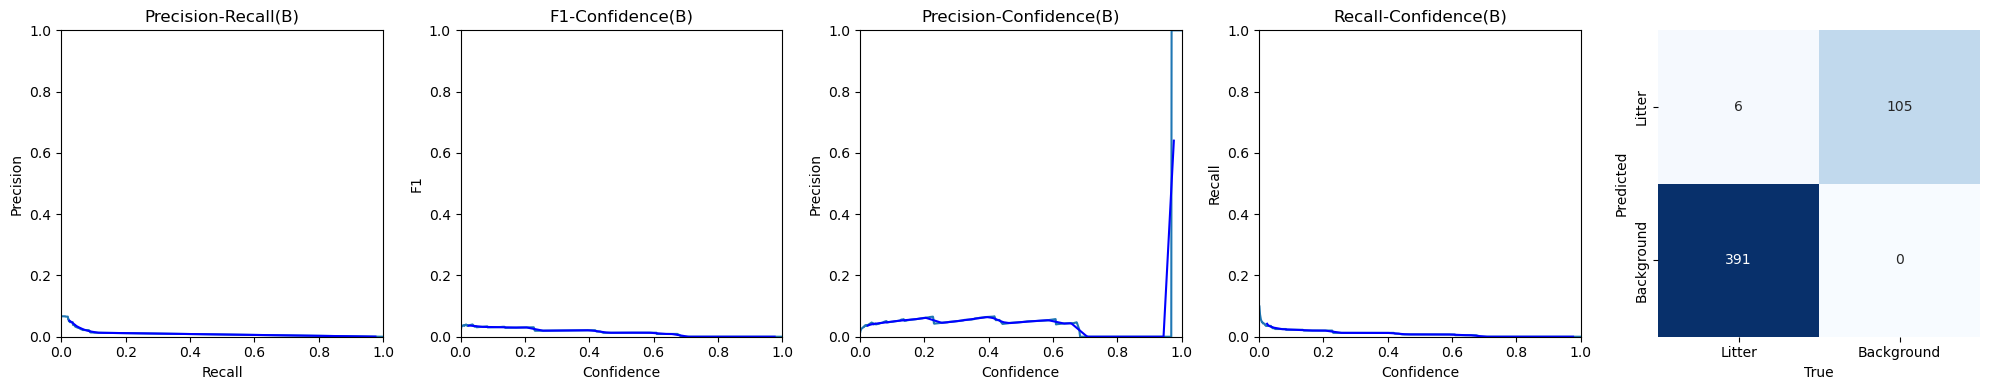

labels changed to two_classes
Saved image to ../out/summary/form8_sea_model-inv_results/preds-gt_only-present-litter-(inverse)_conf-0.3.jpg
Saved image to ../out/summary/form8_sea_model-inv_results/fps_only-present-litter-(inverse)_conf-0.3.jpg
Saved image to ../out/summary/form8_sea_model-inv_results/fns_only-present-litter-(inverse)_conf-0.3.jpg


In [7]:
print("EVALUATING MODEL ON form8 G N DATASET")
evaluate_model(model_name, DATASET_FORM8_INV, ["all present litter (inverse)", "only our litter (inverse)", "only present litter (inverse)"], postfix="-inv")

EVALUATING MODEL ON N G form8 DATASET WITHOUT THE SHORE
labels changed to one_class
Ultralytics 8.3.74 🚀 Python-3.8.20 torch-2.4.1+cu121 CPU (13th Gen Intel Core(TM) i7-13700H)


val: Scanning /home/anna/Datasets/created/hamburg_mapping-form8-val/labels/val... 256 images, 162 backgrounds, 0 corrupt: 100%|██████████| 256/256 [00:00<00:00, 290.28it/s]

val: New cache created: /home/anna/Datasets/created/hamburg_mapping-form8-val/labels/val.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:39<00:00,  2.47s/it]


                   all        256        162      0.246      0.296      0.124     0.0751
Speed: 1.7ms preprocess, 138.6ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val22

ALL PRESENT LITTER (NO SHORE) VALIDATION RESULTS 
Results:
mAP50: 0.124
mAP50-95: 0.075
Precision: 0.246
Recall: 0.296
F1: 0.269


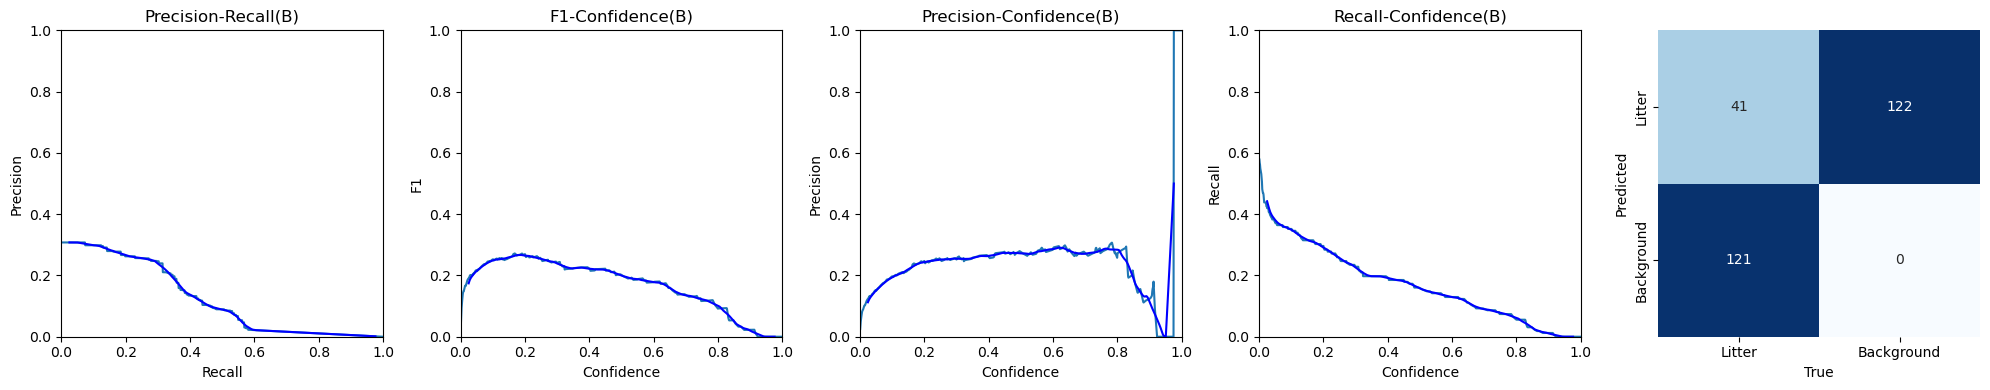

labels changed to two_classes
No boxes present for /home/anna/Datasets/created/hamburg_mapping-form8-val/images/val/0167_15_N_G_(N-(E-N)).png. Skipping...
No boxes present for /home/anna/Datasets/created/hamburg_mapping-form8-val/images/val/0185_15_N_G_(N-(E-N)).png. Skipping...
No boxes present for /home/anna/Datasets/created/hamburg_mapping-form8-val/images/val/0194_15_N_G_(N-(E-N)).png. Skipping...
No boxes present for /home/anna/Datasets/created/hamburg_mapping-form8-val/images/val/0204_15_N_G_(N-(E-N)).png. Skipping...
No boxes present for /home/anna/Datasets/created/hamburg_mapping-form8-val/images/val/0205_15_N_G_(N-(E-N)).png. Skipping...
No boxes present for /home/anna/Datasets/created/hamburg_mapping-form8-val/images/val/0206_15_N_G_(N-(E-N)).png. Skipping...
No boxes present for /home/anna/Datasets/created/hamburg_mapping-form8-val/images/val/0207_15_N_G_(N-(E-N)).png. Skipping...
No boxes present for /home/anna/Datasets/created/hamburg_mapping-form8-val/images/val/0208_15_N

val: Scanning /home/anna/Datasets/created/hamburg_mapping-form8-val/labels/val... 256 images, 218 backgrounds, 0 corrupt: 100%|██████████| 256/256 [00:00<00:00, 258.88it/s]

val: New cache created: /home/anna/Datasets/created/hamburg_mapping-form8-val/labels/val.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:28<00:00,  1.76s/it]


                   all        256         38      0.203      0.638      0.199      0.143
Speed: 1.4ms preprocess, 93.2ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val23

ONLY OUR LITTER (NO SHORE) VALIDATION RESULTS 
Results:
mAP50: 0.199
mAP50-95: 0.143
Precision: 0.203
Recall: 0.638
F1: 0.308


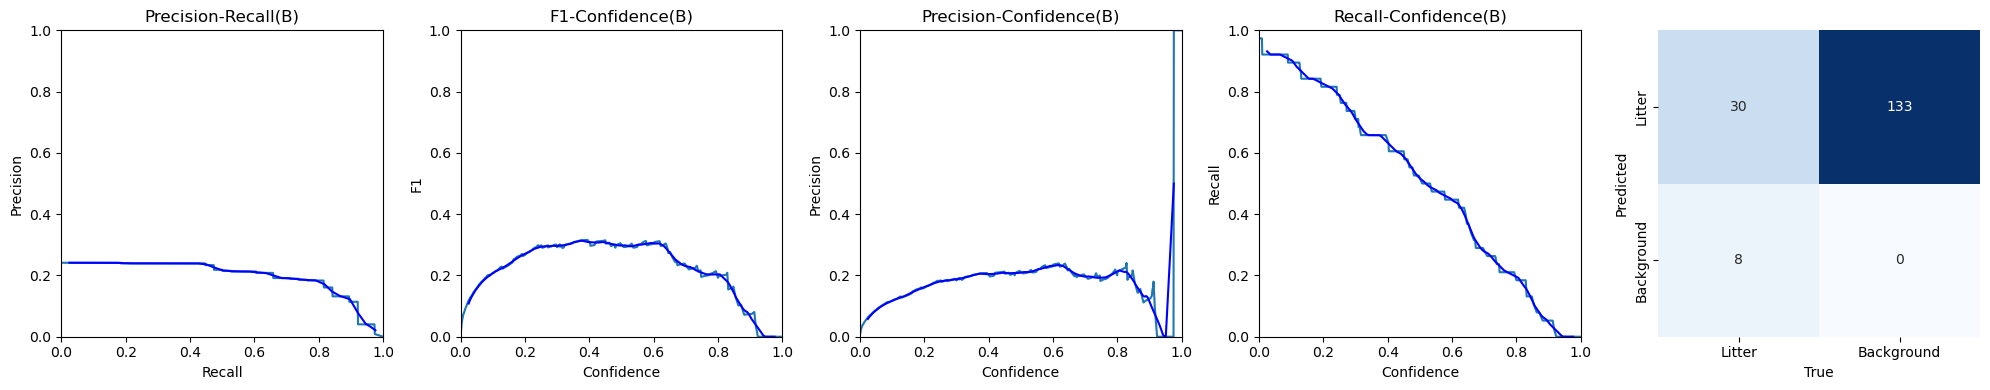

labels changed to two_classes
No boxes present for /home/anna/Datasets/created/hamburg_mapping-form8-val/images/val/0167_15_N_G_(N-(E-N)).png. Skipping...
No boxes present for /home/anna/Datasets/created/hamburg_mapping-form8-val/images/val/0185_15_N_G_(N-(E-N)).png. Skipping...
No boxes present for /home/anna/Datasets/created/hamburg_mapping-form8-val/images/val/0194_15_N_G_(N-(E-N)).png. Skipping...
No boxes present for /home/anna/Datasets/created/hamburg_mapping-form8-val/images/val/0204_15_N_G_(N-(E-N)).png. Skipping...
No boxes present for /home/anna/Datasets/created/hamburg_mapping-form8-val/images/val/0205_15_N_G_(N-(E-N)).png. Skipping...
No boxes present for /home/anna/Datasets/created/hamburg_mapping-form8-val/images/val/0206_15_N_G_(N-(E-N)).png. Skipping...
No boxes present for /home/anna/Datasets/created/hamburg_mapping-form8-val/images/val/0207_15_N_G_(N-(E-N)).png. Skipping...
No boxes present for /home/anna/Datasets/created/hamburg_mapping-form8-val/images/val/0208_15_N

val: Scanning /home/anna/Datasets/created/hamburg_mapping-form8-val/labels/val... 256 images, 180 backgrounds, 0 corrupt: 100%|██████████| 256/256 [00:01<00:00, 185.20it/s]

val: New cache created: /home/anna/Datasets/created/hamburg_mapping-form8-val/labels/val.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:27<00:00,  1.73s/it]


                   all        256        124     0.0794      0.161     0.0346     0.0168
Speed: 1.3ms preprocess, 91.9ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/detect/val24

ONLY PRESENT LITTER (NO SHORE) VALIDATION RESULTS 
Results:
mAP50: 0.035
mAP50-95: 0.017
Precision: 0.079
Recall: 0.161
F1: 0.106


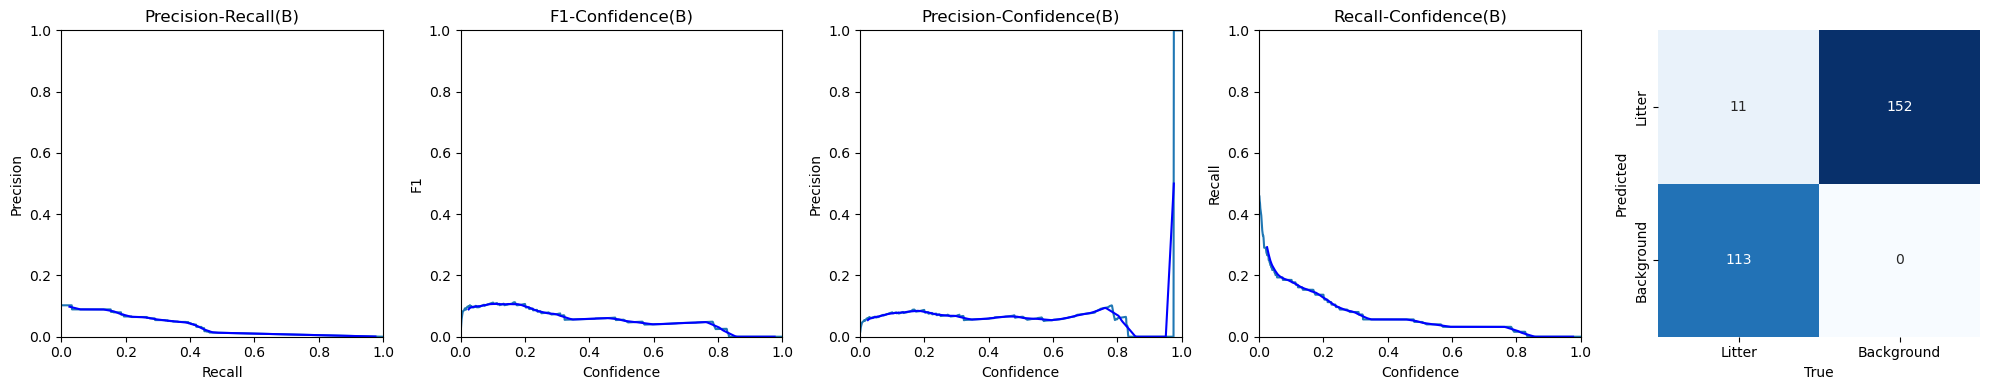

labels changed to two_classes
No boxes present for /home/anna/Datasets/created/hamburg_mapping-form8-val/images/val/0167_15_N_G_(N-(E-N)).png. Skipping...
No boxes present for /home/anna/Datasets/created/hamburg_mapping-form8-val/images/val/0185_15_N_G_(N-(E-N)).png. Skipping...
No boxes present for /home/anna/Datasets/created/hamburg_mapping-form8-val/images/val/0194_15_N_G_(N-(E-N)).png. Skipping...
No boxes present for /home/anna/Datasets/created/hamburg_mapping-form8-val/images/val/0204_15_N_G_(N-(E-N)).png. Skipping...
No boxes present for /home/anna/Datasets/created/hamburg_mapping-form8-val/images/val/0205_15_N_G_(N-(E-N)).png. Skipping...
No boxes present for /home/anna/Datasets/created/hamburg_mapping-form8-val/images/val/0206_15_N_G_(N-(E-N)).png. Skipping...
No boxes present for /home/anna/Datasets/created/hamburg_mapping-form8-val/images/val/0207_15_N_G_(N-(E-N)).png. Skipping...
No boxes present for /home/anna/Datasets/created/hamburg_mapping-form8-val/images/val/0208_15_N

In [ ]:
# Manually move images to 167 to different directory
print("EVALUATING MODEL ON N G form8 DATASET WITHOUT THE SHORE")
evaluate_model(model_name, DATASET_FORM8, ["all present litter (no shore)", "only our litter (no shore)", "only present litter (no shore)"], postfix="-no-shore")

### ONNX EXPORTED

In [6]:
evaluate_model("form8_sea_onnx", DATASET_FORM8, ["all present litter", "only our litter", "only present litter"], onnx=True)

WARNING ⚠️ Unable to automatically guess model task, assuming 'task=detect'. Explicitly define task for your model, i.e. 'task=detect', 'segment', 'classify','pose' or 'obb'.
labels changed to one_class
WARNING ⚠️ updating to 'imgsz=800'. 'train' and 'val' imgsz must be an integer, while 'predict' and 'export' imgsz may be a [h, w] list or an integer, i.e. 'yolo export imgsz=640,480' or 'yolo export imgsz=640'
Ultralytics 8.3.74 🚀 Python-3.8.20 torch-2.4.1+cu121 CPU (13th Gen Intel Core(TM) i7-13700H)
Loading ../models/sea-form8_sea_aug-random_best.onnx for ONNX Runtime inference...
Using ONNX Runtime CPUExecutionProvider
Setting batch=1 input of shape (1, 3, 800, 800)


val: Scanning /home/anna/Datasets/created/hamburg_mapping-form8-val/labels/val.cache... 317 images, 166 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/317 [00:00<?, ?it/s]


RuntimeError: Error in execution: Got invalid dimensions for input: images for the following indices
 index: 3 Got: 800 Expected: 608
 Please fix either the inputs/outputs or the model.

# EVALUATE NEW MODELS


EVALUATING form8_mandrac
labels changed to one_class
Ultralytics 8.3.74 🚀 Python-3.8.20 torch-2.4.1+cu121 CPU (13th Gen Intel Core(TM) i7-13700H)
YOLOv10n summary (fused): 285 layers, 2,694,806 parameters, 0 gradients, 8.2 GFLOPs


val: Scanning /home/anna/Datasets/created/hamburg_mapping-form8-val/labels/val.cache... 317 images, 166 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:34<00:00,  1.74s/it]


                   all        317        435      0.283      0.122      0.113     0.0728
Speed: 1.4ms preprocess, 95.6ms inference, 0.0ms loss, 0.1ms postprocess per image
Results saved to runs/detect/val55


ALL PRESENT LITTER VALIDATION RESULTS

Results:
mAP50: 0.113
mAP50-95: 0.073
Precision: 0.283
Recall: 0.122
F1: 0.170



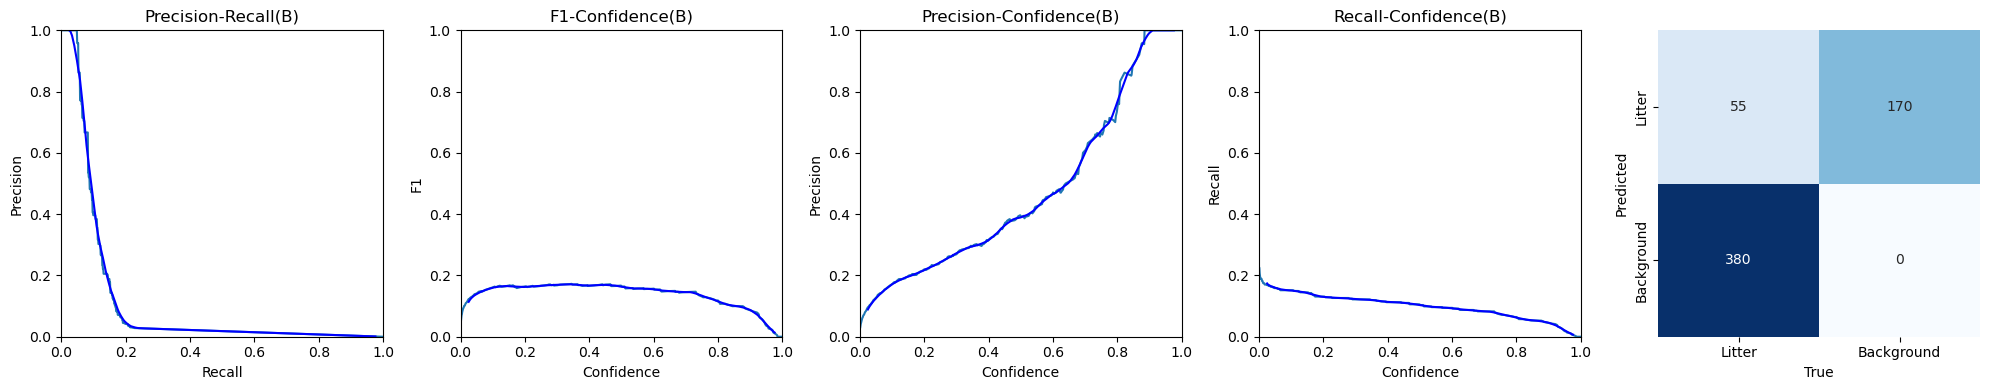

labels changed to two_classes
Saved image to ../out/summary/form8_mandrac_model_results/preds-gt_all-present-litter_conf-0.3.jpg
Saved image to ../out/summary/form8_mandrac_model_results/fps_all-present-litter_conf-0.3.jpg
Saved image to ../out/summary/form8_mandrac_model_results/fns_all-present-litter_conf-0.3.jpg
labels changed to pile_only
Ultralytics 8.3.74 🚀 Python-3.8.20 torch-2.4.1+cu121 CPU (13th Gen Intel Core(TM) i7-13700H)


val: Scanning /home/anna/Datasets/created/hamburg_mapping-form8-val/labels/val.cache... 317 images, 279 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:37<00:00,  1.90s/it]


                   all        317         38      0.887      0.605      0.772      0.496
Speed: 1.7ms preprocess, 103.9ms inference, 0.0ms loss, 0.1ms postprocess per image
Results saved to runs/detect/val56


ONLY OUR LITTER VALIDATION RESULTS

Results:
mAP50: 0.772
mAP50-95: 0.496
Precision: 0.887
Recall: 0.605
F1: 0.719



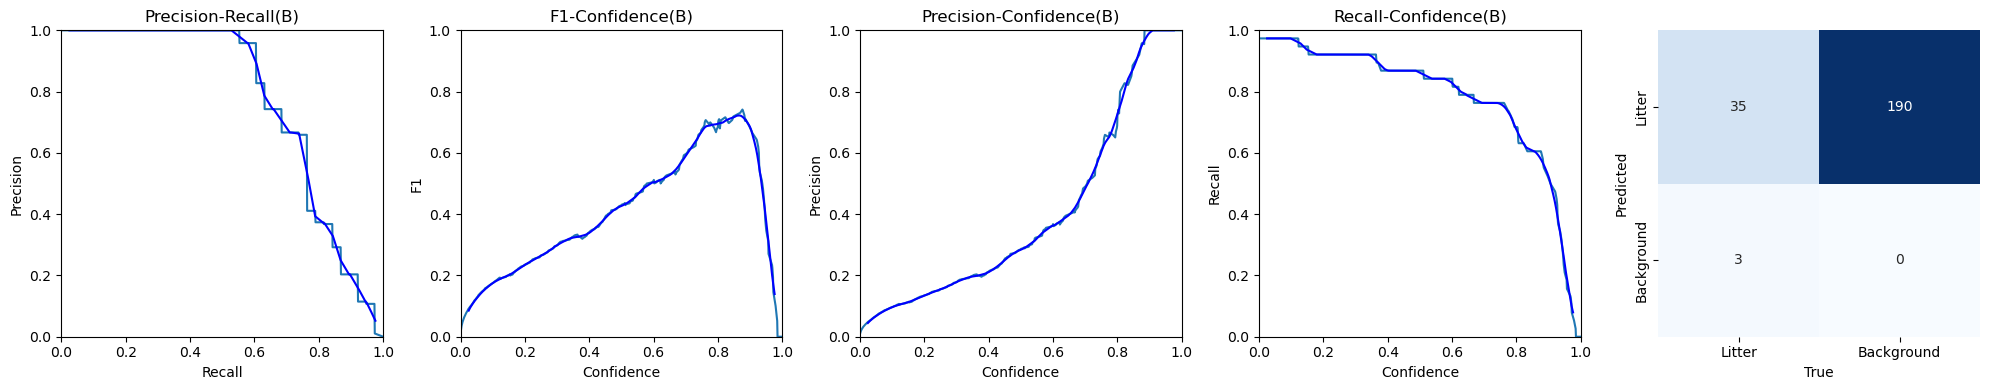

labels changed to two_classes
Saved image to ../out/summary/form8_mandrac_model_results/preds-gt_only-our-litter_conf-0.3.jpg
Saved image to ../out/summary/form8_mandrac_model_results/fps_only-our-litter_conf-0.3.jpg
Saved image to ../out/summary/form8_mandrac_model_results/fns_only-our-litter_conf-0.3.jpg
labels changed to litter_only
Ultralytics 8.3.74 🚀 Python-3.8.20 torch-2.4.1+cu121 CPU (13th Gen Intel Core(TM) i7-13700H)


val: Scanning /home/anna/Datasets/created/hamburg_mapping-form8-val/labels/val.cache... 317 images, 184 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:33<00:00,  1.68s/it]


                   all        317        397     0.0809     0.0705     0.0184     0.0119
Speed: 1.3ms preprocess, 92.4ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val57


ONLY PRESENT LITTER VALIDATION RESULTS

Results:
mAP50: 0.018
mAP50-95: 0.012
Precision: 0.081
Recall: 0.071
F1: 0.075



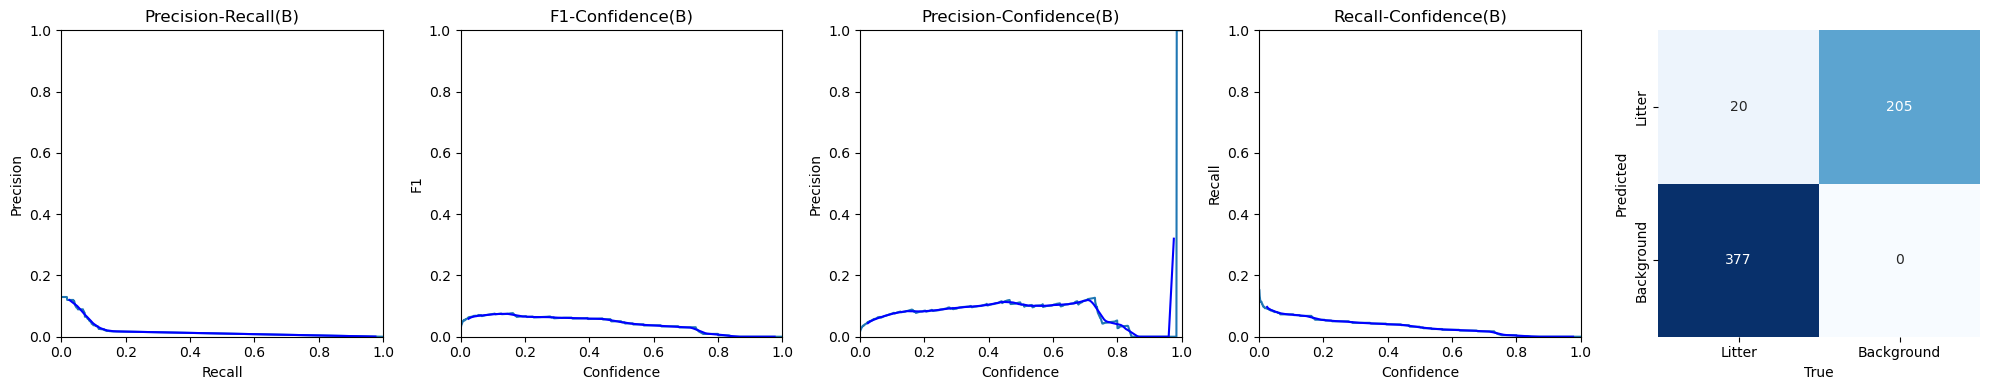

labels changed to two_classes
Saved image to ../out/summary/form8_mandrac_model_results/preds-gt_only-present-litter_conf-0.3.jpg
Saved image to ../out/summary/form8_mandrac_model_results/fps_only-present-litter_conf-0.3.jpg
Saved image to ../out/summary/form8_mandrac_model_results/fns_only-present-litter_conf-0.3.jpg
EVALUATING form8_mandrac-hamburg
labels changed to one_class
Ultralytics 8.3.74 🚀 Python-3.8.20 torch-2.4.1+cu121 CPU (13th Gen Intel Core(TM) i7-13700H)
YOLOv10n summary (fused): 285 layers, 2,694,806 parameters, 0 gradients, 8.2 GFLOPs


val: Scanning /home/anna/Datasets/created/hamburg_mapping-form8-val/labels/val.cache... 317 images, 166 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:39<00:00,  1.95s/it]


                   all        317        435      0.245      0.133      0.124     0.0837
Speed: 1.6ms preprocess, 107.5ms inference, 0.0ms loss, 0.1ms postprocess per image
Results saved to runs/detect/val58


ALL PRESENT LITTER VALIDATION RESULTS

Results:
mAP50: 0.124
mAP50-95: 0.084
Precision: 0.245
Recall: 0.133
F1: 0.173



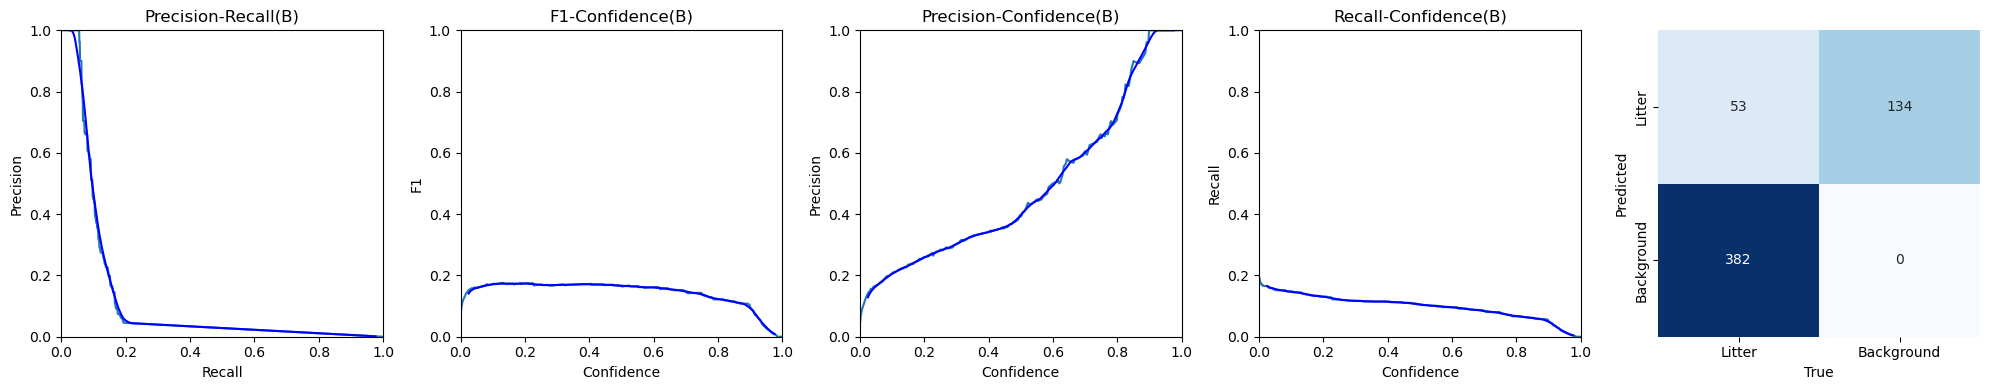

labels changed to two_classes
Saved image to ../out/summary/form8_mandrac-hamburg_model_results/preds-gt_all-present-litter_conf-0.3.jpg
Saved image to ../out/summary/form8_mandrac-hamburg_model_results/fps_all-present-litter_conf-0.3.jpg
Saved image to ../out/summary/form8_mandrac-hamburg_model_results/fns_all-present-litter_conf-0.3.jpg
labels changed to pile_only
Ultralytics 8.3.74 🚀 Python-3.8.20 torch-2.4.1+cu121 CPU (13th Gen Intel Core(TM) i7-13700H)


val: Scanning /home/anna/Datasets/created/hamburg_mapping-form8-val/labels/val.cache... 317 images, 279 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:38<00:00,  1.94s/it]


                   all        317         38        0.9      0.709      0.814      0.543
Speed: 1.6ms preprocess, 109.0ms inference, 0.0ms loss, 0.1ms postprocess per image
Results saved to runs/detect/val59


ONLY OUR LITTER VALIDATION RESULTS

Results:
mAP50: 0.814
mAP50-95: 0.543
Precision: 0.900
Recall: 0.709
F1: 0.793



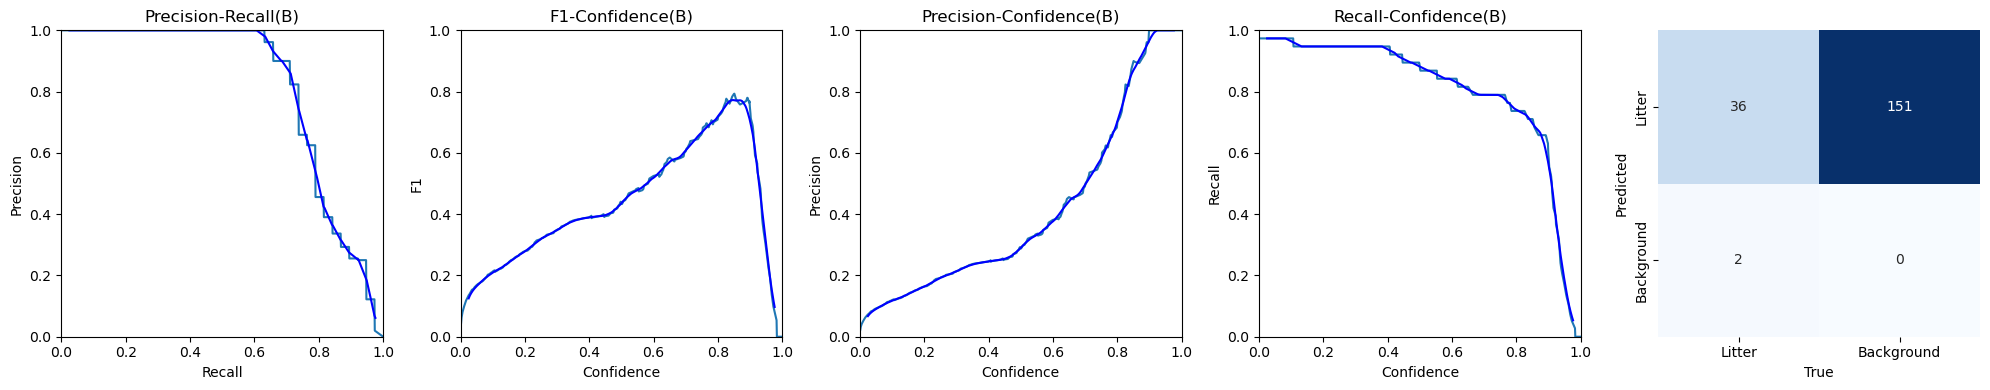

labels changed to two_classes
Saved image to ../out/summary/form8_mandrac-hamburg_model_results/preds-gt_only-our-litter_conf-0.3.jpg
Saved image to ../out/summary/form8_mandrac-hamburg_model_results/fps_only-our-litter_conf-0.3.jpg
Saved image to ../out/summary/form8_mandrac-hamburg_model_results/fns_only-our-litter_conf-0.3.jpg
labels changed to litter_only
Ultralytics 8.3.74 🚀 Python-3.8.20 torch-2.4.1+cu121 CPU (13th Gen Intel Core(TM) i7-13700H)


val: Scanning /home/anna/Datasets/created/hamburg_mapping-form8-val/labels/val.cache... 317 images, 184 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:35<00:00,  1.77s/it]


                   all        317        397     0.0846     0.0705     0.0216     0.0151
Speed: 1.2ms preprocess, 98.6ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/detect/val60


ONLY PRESENT LITTER VALIDATION RESULTS

Results:
mAP50: 0.022
mAP50-95: 0.015
Precision: 0.085
Recall: 0.071
F1: 0.077



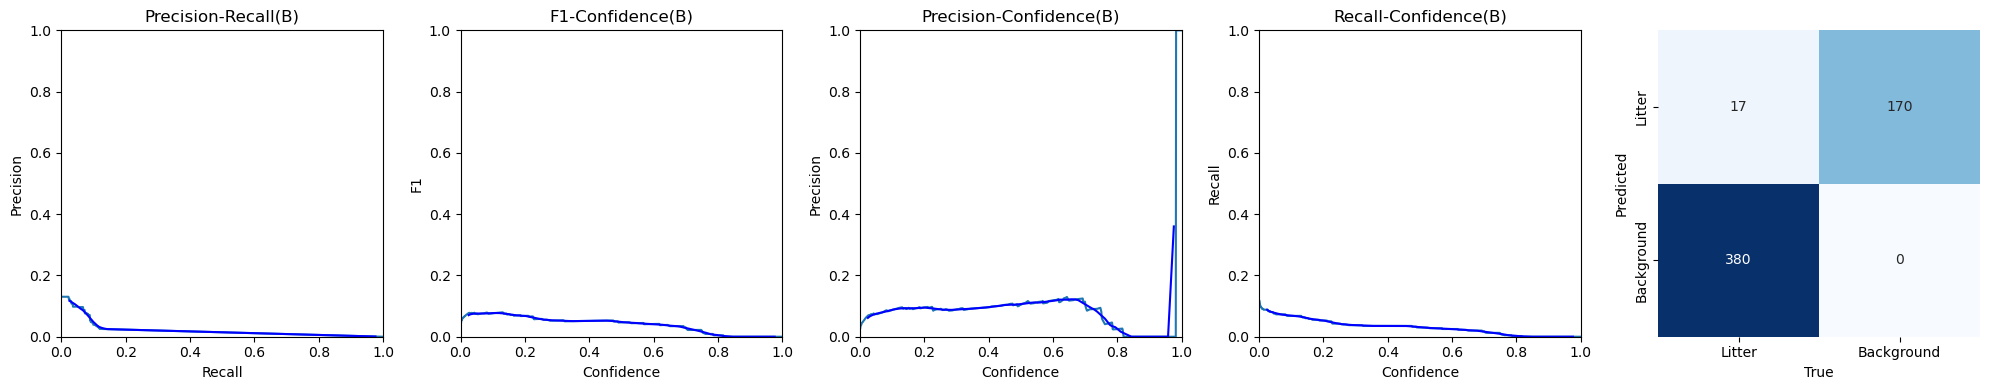

labels changed to two_classes
Saved image to ../out/summary/form8_mandrac-hamburg_model_results/preds-gt_only-present-litter_conf-0.3.jpg
Saved image to ../out/summary/form8_mandrac-hamburg_model_results/fps_only-present-litter_conf-0.3.jpg
Saved image to ../out/summary/form8_mandrac-hamburg_model_results/fns_only-present-litter_conf-0.3.jpg


In [8]:
for model_name in ("form8_mandrac", "form8_mandrac-hamburg"):
    print(f"EVALUATING {model_name}")
    evaluate_model(model_name, DATASET_FORM8, ["all present litter", "only our litter", "only present litter"])   

EVALUATING form2_mandrac
labels changed to one_class
Ultralytics 8.3.74 🚀 Python-3.8.20 torch-2.4.1+cu121 CPU (13th Gen Intel Core(TM) i7-13700H)
YOLOv10n summary (fused): 285 layers, 2,694,806 parameters, 0 gradients, 8.2 GFLOPs


val: Scanning /home/anna/Datasets/created/hamburg_mapping-form2-val/labels/val.cache... 317 images, 166 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:39<00:00,  2.00s/it]


                   all        317        435      0.346      0.106     0.0779     0.0523
Speed: 1.7ms preprocess, 110.6ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/detect/val61


ALL PRESENT LITTER VALIDATION RESULTS

Results:
mAP50: 0.078
mAP50-95: 0.052
Precision: 0.346
Recall: 0.106
F1: 0.162



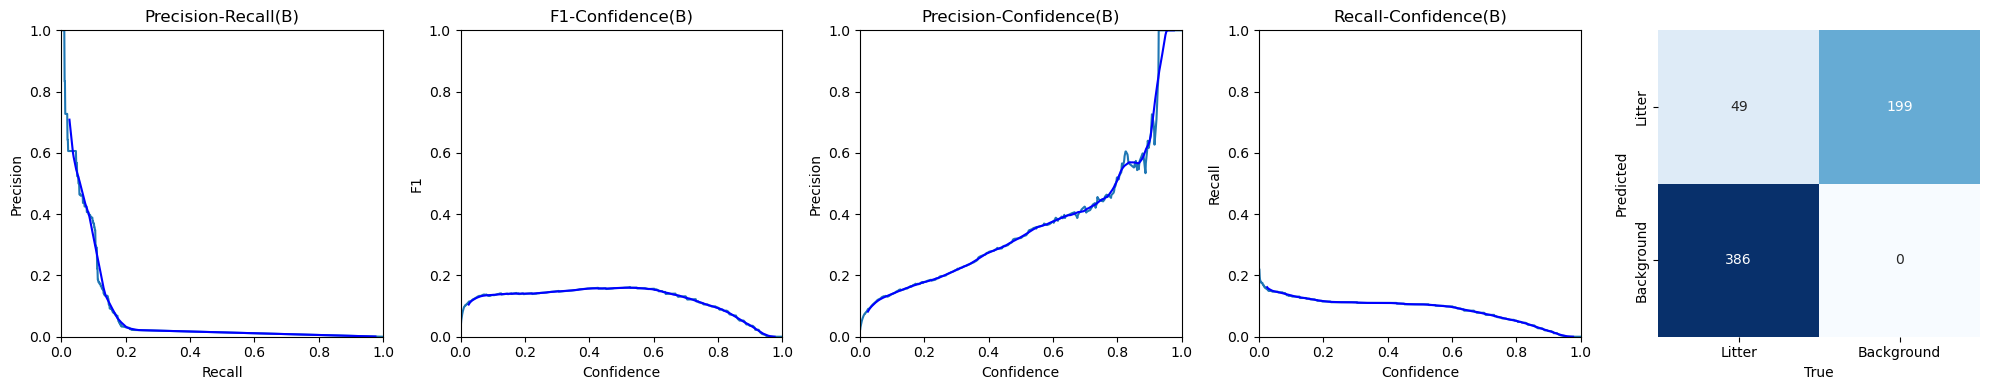

labels changed to two_classes
Saved image to ../out/summary/form2_mandrac_model_results/preds-gt_all-present-litter_conf-0.3.jpg
Saved image to ../out/summary/form2_mandrac_model_results/fps_all-present-litter_conf-0.3.jpg
Saved image to ../out/summary/form2_mandrac_model_results/fns_all-present-litter_conf-0.3.jpg
labels changed to pile_only
Ultralytics 8.3.74 🚀 Python-3.8.20 torch-2.4.1+cu121 CPU (13th Gen Intel Core(TM) i7-13700H)


val: Scanning /home/anna/Datasets/created/hamburg_mapping-form2-val/labels/val.cache... 317 images, 279 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:37<00:00,  1.87s/it]


                   all        317         38      0.362      0.507      0.462      0.312
Speed: 1.6ms preprocess, 104.0ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/detect/val62


ONLY OUR LITTER VALIDATION RESULTS

Results:
mAP50: 0.462
mAP50-95: 0.312
Precision: 0.362
Recall: 0.507
F1: 0.422



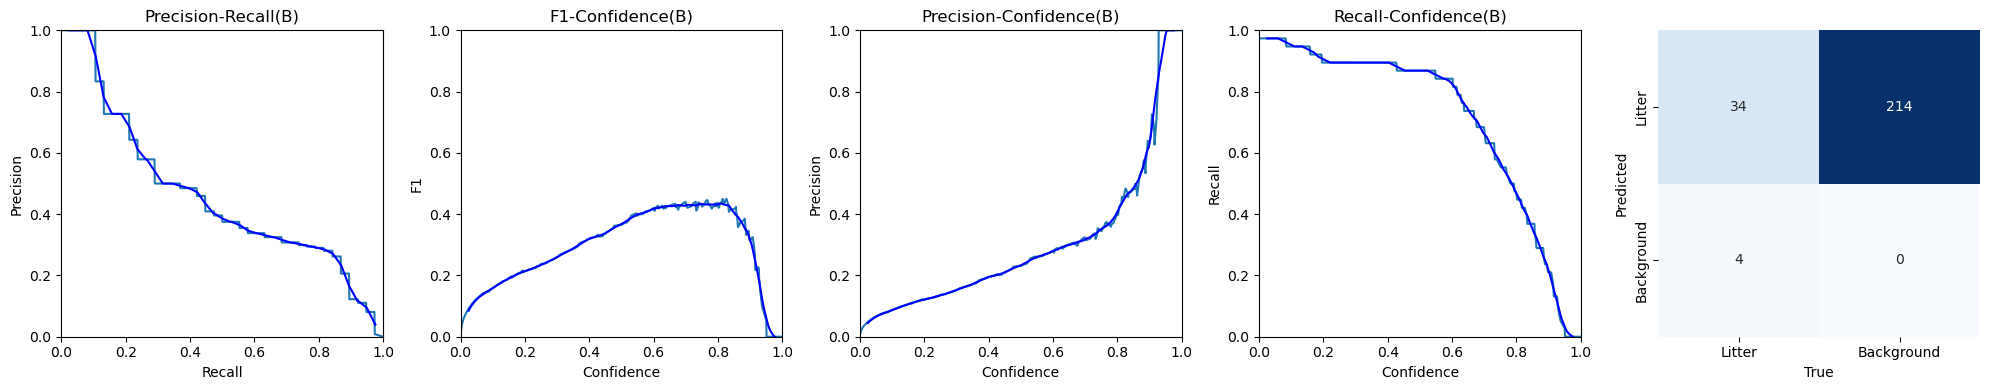

labels changed to two_classes
Saved image to ../out/summary/form2_mandrac_model_results/preds-gt_only-our-litter_conf-0.3.jpg
Saved image to ../out/summary/form2_mandrac_model_results/fps_only-our-litter_conf-0.3.jpg
Saved image to ../out/summary/form2_mandrac_model_results/fns_only-our-litter_conf-0.3.jpg
labels changed to litter_only
Ultralytics 8.3.74 🚀 Python-3.8.20 torch-2.4.1+cu121 CPU (13th Gen Intel Core(TM) i7-13700H)


val: Scanning /home/anna/Datasets/created/hamburg_mapping-form2-val/labels/val.cache... 317 images, 184 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:35<00:00,  1.79s/it]


                   all        317        397     0.0528      0.063     0.0138    0.00888
Speed: 1.4ms preprocess, 99.4ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val63


ONLY PRESENT LITTER VALIDATION RESULTS

Results:
mAP50: 0.014
mAP50-95: 0.009
Precision: 0.053
Recall: 0.063
F1: 0.057



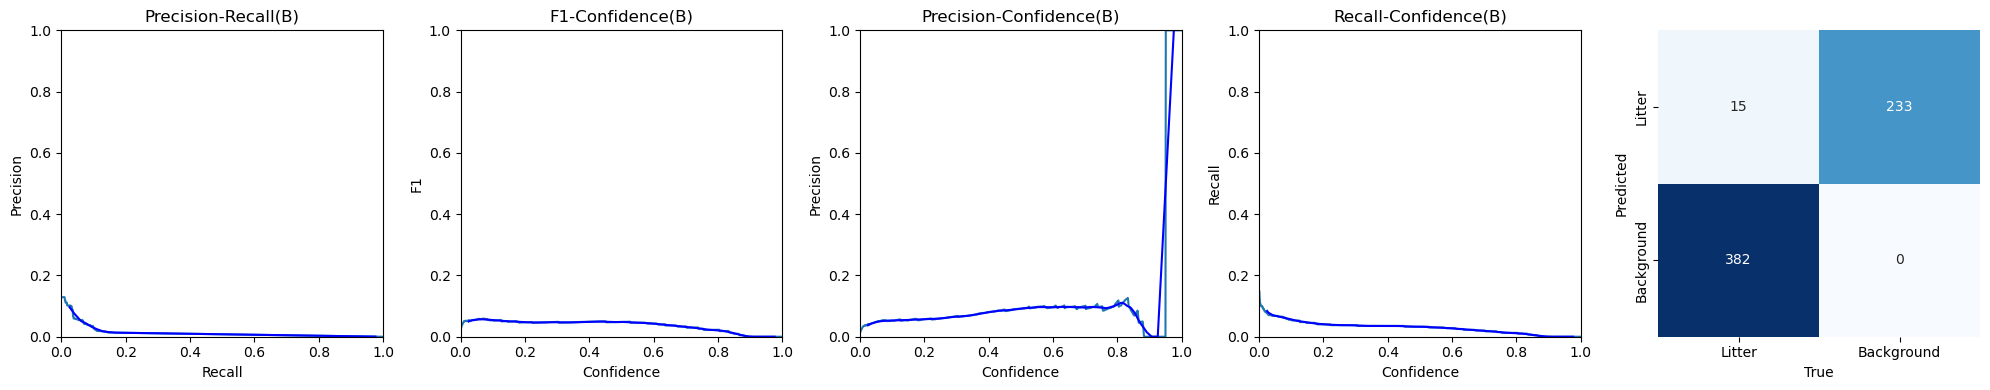

labels changed to two_classes
Saved image to ../out/summary/form2_mandrac_model_results/preds-gt_only-present-litter_conf-0.3.jpg
Saved image to ../out/summary/form2_mandrac_model_results/fps_only-present-litter_conf-0.3.jpg
Saved image to ../out/summary/form2_mandrac_model_results/fns_only-present-litter_conf-0.3.jpg
EVALUATING form2_mandrac-hamburg
labels changed to one_class
Ultralytics 8.3.74 🚀 Python-3.8.20 torch-2.4.1+cu121 CPU (13th Gen Intel Core(TM) i7-13700H)
YOLOv10n summary (fused): 285 layers, 2,694,806 parameters, 0 gradients, 8.2 GFLOPs


val: Scanning /home/anna/Datasets/created/hamburg_mapping-form2-val/labels/val.cache... 317 images, 166 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:35<00:00,  1.76s/it]


                   all        317        435      0.361      0.136      0.118     0.0751
Speed: 1.4ms preprocess, 96.7ms inference, 0.0ms loss, 0.1ms postprocess per image
Results saved to runs/detect/val64


ALL PRESENT LITTER VALIDATION RESULTS

Results:
mAP50: 0.118
mAP50-95: 0.075
Precision: 0.361
Recall: 0.136
F1: 0.197



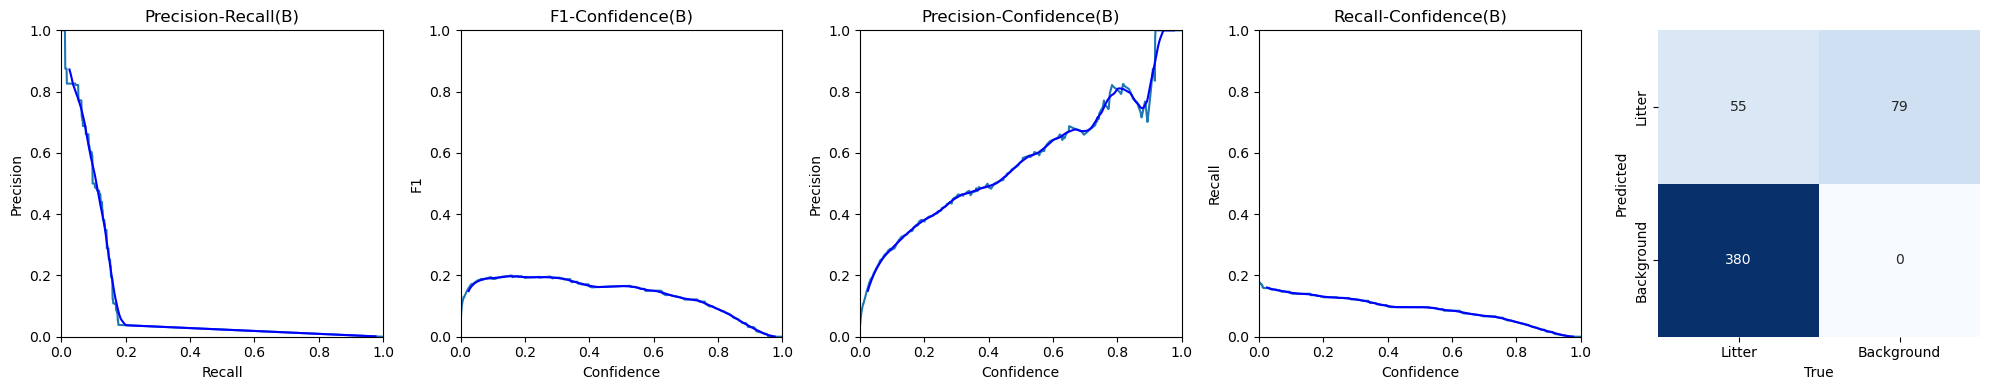

labels changed to two_classes
Saved image to ../out/summary/form2_mandrac-hamburg_model_results/preds-gt_all-present-litter_conf-0.3.jpg
Saved image to ../out/summary/form2_mandrac-hamburg_model_results/fps_all-present-litter_conf-0.3.jpg
Saved image to ../out/summary/form2_mandrac-hamburg_model_results/fns_all-present-litter_conf-0.3.jpg
labels changed to pile_only
Ultralytics 8.3.74 🚀 Python-3.8.20 torch-2.4.1+cu121 CPU (13th Gen Intel Core(TM) i7-13700H)


val: Scanning /home/anna/Datasets/created/hamburg_mapping-form2-val/labels/val.cache... 317 images, 279 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:37<00:00,  1.87s/it]


                   all        317         38      0.563      0.677      0.644      0.453
Speed: 1.6ms preprocess, 102.1ms inference, 0.0ms loss, 0.1ms postprocess per image
Results saved to runs/detect/val65


ONLY OUR LITTER VALIDATION RESULTS

Results:
mAP50: 0.644
mAP50-95: 0.453
Precision: 0.563
Recall: 0.677
F1: 0.614



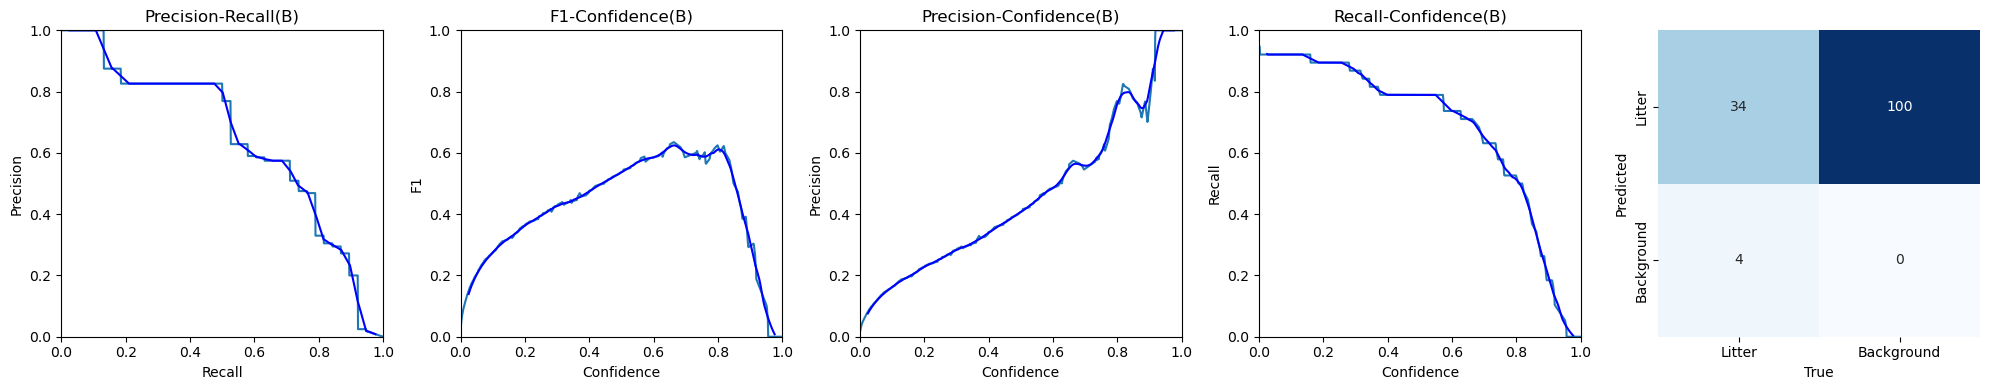

labels changed to two_classes
Saved image to ../out/summary/form2_mandrac-hamburg_model_results/preds-gt_only-our-litter_conf-0.3.jpg
Saved image to ../out/summary/form2_mandrac-hamburg_model_results/fps_only-our-litter_conf-0.3.jpg
Saved image to ../out/summary/form2_mandrac-hamburg_model_results/fns_only-our-litter_conf-0.3.jpg
labels changed to litter_only
Ultralytics 8.3.74 🚀 Python-3.8.20 torch-2.4.1+cu121 CPU (13th Gen Intel Core(TM) i7-13700H)


val: Scanning /home/anna/Datasets/created/hamburg_mapping-form2-val/labels/val.cache... 317 images, 184 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:40<00:00,  2.03s/it]


                   all        317        397      0.127     0.0709     0.0239     0.0126
Speed: 1.6ms preprocess, 112.9ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val66


ONLY PRESENT LITTER VALIDATION RESULTS

Results:
mAP50: 0.024
mAP50-95: 0.013
Precision: 0.127
Recall: 0.071
F1: 0.091



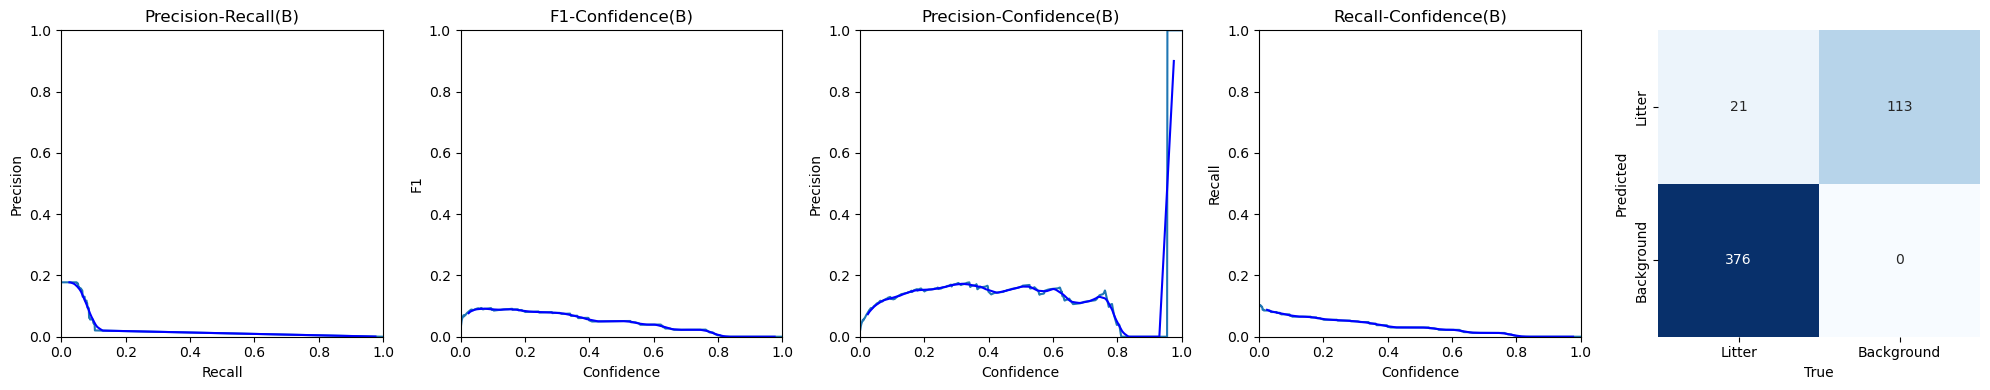

labels changed to two_classes
Saved image to ../out/summary/form2_mandrac-hamburg_model_results/preds-gt_only-present-litter_conf-0.3.jpg
Saved image to ../out/summary/form2_mandrac-hamburg_model_results/fps_only-present-litter_conf-0.3.jpg
Saved image to ../out/summary/form2_mandrac-hamburg_model_results/fns_only-present-litter_conf-0.3.jpg


In [9]:
for model_name in ("form2_mandrac", "form2_mandrac-hamburg"):
    print(f"EVALUATING {model_name}")
    evaluate_model(model_name, DATASET_FORM2, ["all present litter", "only our litter", "only present litter"])   